# Notebook for developing code that marks a simple visualisation
Jim Smith 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import plotchecker



from ideal_visualiser import cluster_and_visualise as ideal
from grid_clusters import cluster_and_visualise as grid_clusters
from grid_noclusters import cluster_and_visualise as grid_noclusters
from grid_randclusters import cluster_and_visualise as grid_randclusters


from one_ax_clusters import cluster_and_visualise as one_ax_clusters
from one_ax_noclusters import cluster_and_visualise as one_ax_noclusters
from one_ax_randclusters import cluster_and_visualise as one_ax_randclusters
from onefig import cluster_and_visualise as one_fig
#from student import cluster_and_visualise as student


from err_msg import processError, getExceptionDetails
from typing import Any

# Make data
idea is four features, two seperate data into two clusters, one is 0/1 at random, one is U(0,1)

In [2]:
num = 50
num_f = 4
feature_names= ("randchoice","f2","f1","rand_uniform")
vals = (0.0,0.2,0.4,0.6,0.8)
data = np.zeros((num,num_f),dtype=float)
for i in range (num):
    data[i][2] = (i%2) + 0.5 + np.random.normal(loc=0.25,scale=0.1)
    data[i][1] = np.random.normal(loc=1.0,scale=0.25)
    data[i][0] = vals [np.random.randint(5)]
    data[i][3] = np.random.uniform(0.0,1.0)
np.savetxt('visdata.csv',data,fmt="%.4f",delimiter=',')

perfect_clusters = np.zeros(num,dtype=int)
for i in range(num):
    if i%2:
        perfect_clusters[i] = 1



# Functions to calculate different checks

In [3]:
def check_fig_type(fig:Any)-> tuple[bool,bool,str] :
    ''' function that checks that variable fig is a matplotlib figure'''

    manual_marking= False
    wrong_types=False
    message = ""

    if  isinstance(fig, matplotlib.figure.Figure):
        message += ("Your code correctly returned first param of type Figure.\n")
        
    #except in rate cases of scatter plotd created directly by plt.scatter
    elif isinstance(fig,matplotlib.collections.PathCollection):
        manual_marking=True
        message += ('Your code returned a first param of type pathcollection, '
                    'which is unusual, and will need manual marking.\n')
    else:
        message = ( "Error, your code does not return the right things.\n"
                    "The first thing returned should be of type matplotlib.figure.Figure, "
                   f"however your code return something of type {type(fig)}.\n"
                  )
        wrong_types = True
    return  manual_marking, wrong_types,message

In [21]:
def check_ax_type(ax:Any,numfeatures=2)-> tuple[bool,bool,bool,str] :
    ''' function that checks that ax variables is either an axes subplot or an array of them'''
    wrong_types=False
    message = ""
    single_ax= False
    manual_marking= False
        
 
    axtype = type(ax)
    
    #simple figure with one plot created using fig.subplots
    if issubclass(axtype, matplotlib.axes.SubplotBase):
        single_ax = True
        message += ("You have returned a figure with a single plot in it.\n"
                    "This is not enough to fully visualise this dataset.\n"
                   )

    
    elif isinstance (ax, np.ndarray):
        single_ax = False
        num_dimensions = len(ax.shape)

        # check organisation of array
        message += f'You have returned an array with {num_dimensions} dimensions, of sizes {ax.shape}, '

        if   num_dimensions != 2 or ax.shape[0]!=numfeatures or ax.shape[1] !=numfeatures:
            message += ("but to compare combinations of features pairwise this should normally be "
                         f" a 2-D array of size {numfeatures}X{numfeatures}.\n"
                       )
            message += "this will require manual marking.\n"
            manual_marking = True
        else:
            message += "which is the ideal arrangement.\n"

            
        #check contentys of array
        if len(ax.shape)==1:
            contents_type= type(ax[0])
        else:
            contents_type= type(ax[0][0])                
        if not issubclass(contents_type, matplotlib.axes.SubplotBase):
                message += (f"Your array ax contains things of type {contents_type}."
                        "the standard  call `fig,ax = plt.subplots()` "
                        "makes ax an array with datatype  matplotlib.axes._subplots.AxesSubplot.\n"
                       )
                wrong_types=True
        else:
            message += "Your ax array correctly contains objects of  type AxesSubplot.\n" 
        
    else:
        message += ( "Error, your code does not return the right things.\n"
                    "The second thing returned should either be: \n"
                     " - one thing of type  matplotlib.axes._subplots.AxesSubplot, or \n"
                     " - a numpy.ndarray of things of type matplotlib.axes._subplots.AxesSubplot\n"
                     f"However your code return something of type {type(ax)}"
                  )
        wrong_types = True
      
    return manual_marking, wrong_types,single_ax,message

In [5]:
def check_name_in_title(fig:Any,ax:Any,single_ax:bool,student_name:str)->tuple[int,str]:
    title_quality=0
    quality_strings =('Your visualisation does not contain a title.\n',
                      'Your visualisation has a title, but it does not contain your user name  as required.\n',
                      'Your visualisation  correctly has your user name in the title.\n'
            )
    the_title= ""
    
    if(single_ax):
        #try to get from figure first, 
        if ('_suptitle'  in fig.__dict__.keys()):
            the_title = fig._suptitle.get_text()
        # then ax if that hasnt worked
        if the_title=="" or the_title==None:
            the_title= ax.get_title()
            
        if the_title=="" or the_title==None:
            title_quality = 0 #missing
        elif student_name in the_title:
            title_quality = 2 #good
        else :  
            title_quality = 1 #inadequate

    
    else:
        if ('_suptitle' not in fig.__dict__.keys()):
            title_quality = 0 #non-existent
        else:    
            the_title=fig._suptitle.get_text()
        
            if student_name in the_title:
                title_quality = 2 #good
            else :  
                title_quality = 1 #inadequate

    return title_quality, quality_strings[title_quality]
    
    
    

In [19]:
def test_clusters (ax:Any, single_ax:bool) -> tuple[int,str]:
    '''function to test whether the clustering given to an ax matches the ideal version
    parameters ax: either single axessubplot or a ndarray
    parameter single_ax: tells type of ax
    '''
    message = ""
    cluster_quality = 0 #non-existent
    
    if (single_ax):
        A = ax._children[0]._A
    else:
        A = ax[2,0]._children[0]._A

    
    if(type(A) ==type(None)):
        cluster_quality = 0 #non-existent 
        message = "Your plot does not appear to have any different colors.\n"
        
    elif( np.all(A == A[0])):
        cluster_quality = 0 #non-existent 
        message = "Your plot is given a set of colours to use, but they are all the same.\n"
    else:
        A = A.astype(int)
        diff = sum(A-perfect_clusters)
        if  (diff == 0) or (diff ==len(A)):
            #allow for cluster with inverse assignments
            cluster_quality = 2 #perfect
            message = "Your plot colours match the ideal clustering for this data.\n"
        else:
            cluster_quality = 1 #present but not very good
            message = ("Your plot has different colours, "
                       "but they do not match the  clustering "
                       "this dataset was designed to contain.\n"
                      )
    return cluster_quality,message   

In [7]:
def check_axis_labels (ax:Any, single_ax:bool,feature_names) -> tuple[int,str]:
    '''function to test whether there are axis labels
    parameters ax: either single axessubplot or a ndarray
    parameter single_ax: tells type of ax
    '''
    message = ""
    label_quality = 0 #non-existent
    
    if (single_ax):
        x_label = ax.get_xlabel()
        y_label=ax.get_ylabel()
        
        if x_label==None or x_label=="" or y_label==None or y_label=="" :
            label_quality=0
            message = "One or more axis labels are missing.\n"
            
        elif x_label in feature_names and y_label in feature_names :
            if x_label != y_label:
                label_quality=2
                message = "Axis labels show different valid feature names.\n"
            else:
                label_quality=1
                message= "Both Axis Labels are the same.\n"
        else:
            label_quality=0
            message = "One or both axis labels are not valid feature names.\n"
            
        
    else:
        names_used = {}
        for name in feature_names:
            names_used[name] = 0
        for row in range(ax.shape[0]):
            for col in range(ax.shape[1]):
                the_ax= ax[row][col]
                x_label = the_ax.get_xlabel()
                y_label=the_ax.get_ylabel() 
                #test values
                if (x_label != ""):
                    if  x_label not in feature_names :
                        label_quality=0
                        message = "One or more axis labels are not valid feature names.\n"
                        break
                    else:
                        #increment usage counters
                        val= names_used[x_label]
                        names_used[x_label] = val+1
                if(y_label != ""):
                    if  y_label not in feature_names:
                        label_quality=0
                        message = "One or more axis labels are not valid feature names.\n"
                        break
                    else:
                        val= names_used[y_label]
                        names_used[y_label] = val+1
        
        if testing:
            #for key, val in names_used.items():
            #    print(f'{key}:{val}\n')
            pass
        vals = list(names_used.values())
        
        if all(x==2 for x in vals):
            message= "Each label appears twice, as expected.\n"
            label_quality=3
        elif all(x==len(feature_names) for x in vals):
            message= ( f"Each label appears {len(feature_names)} times " 
                      " which is a little cluttered, but ok.\n"
                    )
            label_quality=2
        else:
            label_quality=1
            message = "All the axis labels provided are valid feature names.\n" 
            if any (x==0 for x in vals):
                message += ("However, some feature names do not appear as axis labels\n")
            else:
                message += ("However, the number of times each appears is unusual.\n")
            
            
    return label_quality,message   

In [69]:
def check_visualisation(func:Any,datafile:str,K:int,feature_names:Any,student_name:str= "j4-smith",testname:str="")->tuple[int,str]:
    ''' Function that runs various tests on a visualisation 
    Parameters: func provided by student's code, student name, testname
    Returns: Score and message
    '''
    
    content_score = 0
    presentation_score = 0
    done_marking = False
    REFER = -1
    title_quality= 0
    label_quality =0
    cluster_quality =0
    message = ""
    
    
    # start by testing the return types
    fig,ax = func(datafile, K,feature_names )

    manual_marking,wrong_types,message1 = check_fig_type(fig)
    if(testing):    
        #print (f"Checked fig, needs manual_marking= {manual_marking}, "
           #f"wrongtype = {wrong_types}\nmessage= {message1}\n")
        pass
    message += message1
    if (manual_marking):
        content_score= REFER,
        presentation_score = REFER
        done_marking= True
    elif wrong_types:
        content_score= 0,
        presentation_score = 0
        done_marking= True    
    else :
        manual_marking,wrong_types,single_ax,message2 = check_ax_type(ax,numfeatures=len(feature_names))
        if(testing):
            #print (f"checking ax, manual_marking= {manual_marking}, " 
               #f"wrongtype = {wrong_types}, single_ax= {single_ax}\nmessage= {message2}\n")
            pass
        message = message + message2
        if (manual_marking):
            content_score= REFER,
            presentation_score = REFER
            done_marking= True
        elif wrong_types:
            content_score= 0,
            presentation_score = 0
            done_marking= True                  

    if(manual_marking):
        return -1, message

    #if all ok to proceed with the checking the content ...
    if not done_marking:
        
        #are the diagonals on a matrix histograms?
        diagonal_quality = 0
        if not single_ax:
            if isinstance(ax[0][0]._children[0],matplotlib.patches.Rectangle):
                diagonal_quality = 1
        #is there clustering 0 (none),1,2
        cluster_quality,message5= test_clusters (ax, single_ax)
        message +=message5
        
        #is there a correct title? 0,1,2
        title_quality,message3 = check_name_in_title(fig,ax,single_ax,student_name)
        message += message3
        
        #is correct data in the clusters 0,1,2
        #not currently implemented
        
        #are there axis labels? 0,1,2,3
        label_quality, message4 = check_axis_labels (ax, single_ax,feature_names) 
        message += message4
        
  
        
 
        
        #Calculate Marks
        message += "\n\n\n=== Overall: \n"
        #content mark
        if(single_ax):
            message += "You score 10/20 for the basic content having just one plot,\n"
            message +=f"      and {10*cluster_quality}/20 for the quality of your clustering.\n"
            content_score = 10 + 10*cluster_quality     
        else:
            message +=  "You score 20/20 for the basic content having an array of plots.\n"
            message += f"      and {10*cluster_quality}/20 for the quality of your clustering.\n"
            if(diagonal_quality>0):   
                message +="      and an extra 10 for having different plots on the diagonals\n"
            content_score = 20 + 10* cluster_quality +10*diagonal_quality
 
        message +=f"Altogether, you score {content_score}/50 for the contents of your visualisation.\n\n"

           
        #presentation mark
        if(label_quality==0 and title_quality==0):
            presentation_score = 10
            message +="You do not have a title or labels so you score 10 for presentation"
        else:
            message+=f"You score {10*label_quality}/30 for the quality of your labelling,\n"
            message+=f"      and {10*title_quality}/20 for how well your title met the specs..\n"
            presentation_score= 10 * (label_quality + title_quality)
        message += f"Altogether, you score {presentation_score}/50 for presentation of  your visualisation.\n\n"
        
        message+=f"\nIn total you score {content_score+presentation_score}/100.\n"
    
    
    return content_score+presentation_score,message
        
    

# Variables for testing

In [70]:
student_name= "j4-smith"

testing=True
datafile= 'visdata.csv'
K=2
testing_dict = {"ideal":ideal, 
                "oneax_clusters":one_ax_clusters, 
                "oneax_noclusters":one_ax_noclusters, 
                "oneax_randclusters":one_ax_randclusters, 
                "oneFig":one_fig, 
                "grid_clusters":grid_clusters,
                "grid_noclusters":grid_noclusters,
                "grid_randclusters":grid_randclusters
               }

In [71]:
#fig,ax = ideal(datafile,K,feature_names)
#for key,val in ax[0][0].__dict__.items():
#    print(f'{key}:{val}')
#print(isinstance(ax[0][0]._children[0],matplotlib.patches.Rectangle))

# Here is the code checking with my dict of types

*****testing.   ideal *****



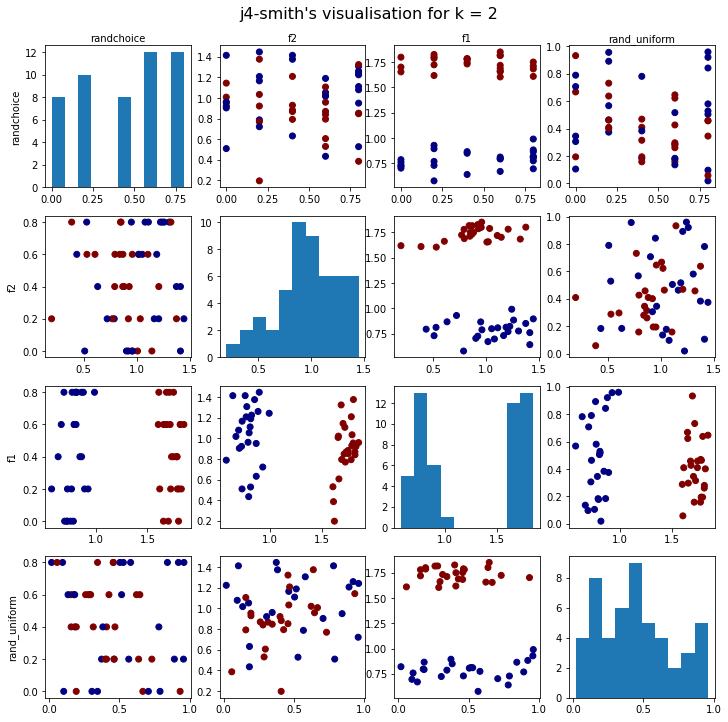

Your code correctly returned first param of type Figure.
You have returned an array with 2 dimensions, of sizes (4, 4), which is the ideal arrangement.
Your ax array correctly contains objects of  type AxesSubplot.
Your plot colours match the ideal clustering for this data.
Your visualisation  correctly has your user name in the title.
Each label appears twice, as expected.



=== Overall: 
You score 20/20 for the basic content having an array of plots.
      and 20/20 for the quality of your clustering.
      and an extra 10 for having different plots on the diagonals
Altogether, you score 50/50 for the contents of your visualisation.

You score 30/30 for the quality of your labelling,
      and 20/20 for how well your title met the specs..
Altogether, you score 50/50 for presentation of  your visualisation.


In total you score 100/100.

Total score 100 

*****testing.   oneax_clusters *****



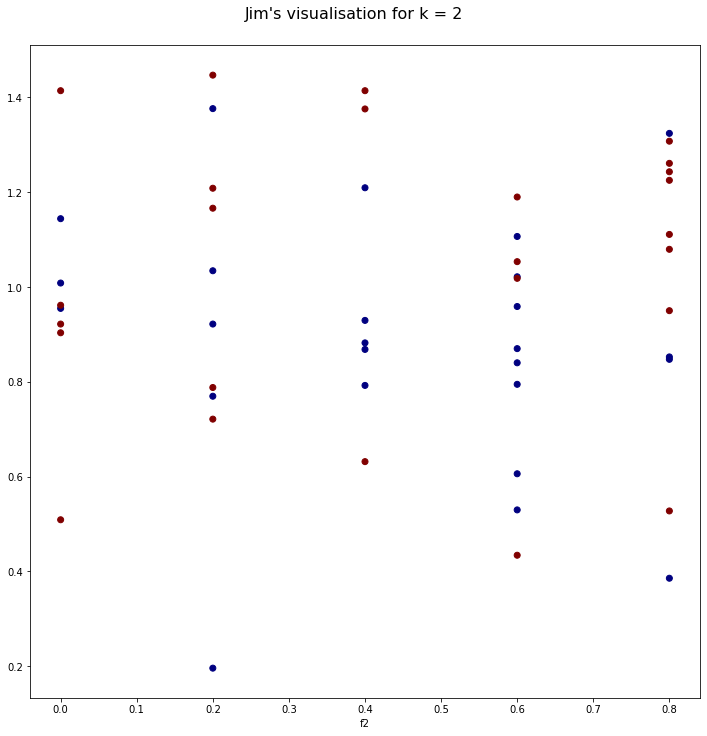

Your code correctly returned first param of type Figure.
You have returned a figure with a single plot in it.
This is not enough to fully visualise this dataset.
Your plot colours match the ideal clustering for this data.
Your visualisation has a title, but it does not contain your user name  as required.
One or more axis labels are missing.



=== Overall: 
You score 10/20 for the basic content having just one plot,
      and 20/20 for the quality of your clustering.
Altogether, you score 30/50 for the contents of your visualisation.

You score 0/30 for the quality of your labelling,
      and 10/20 for how well your title met the specs..
Altogether, you score 10/50 for presentation of  your visualisation.


In total you score 40/100.

Total score 40 

*****testing.   oneax_noclusters *****



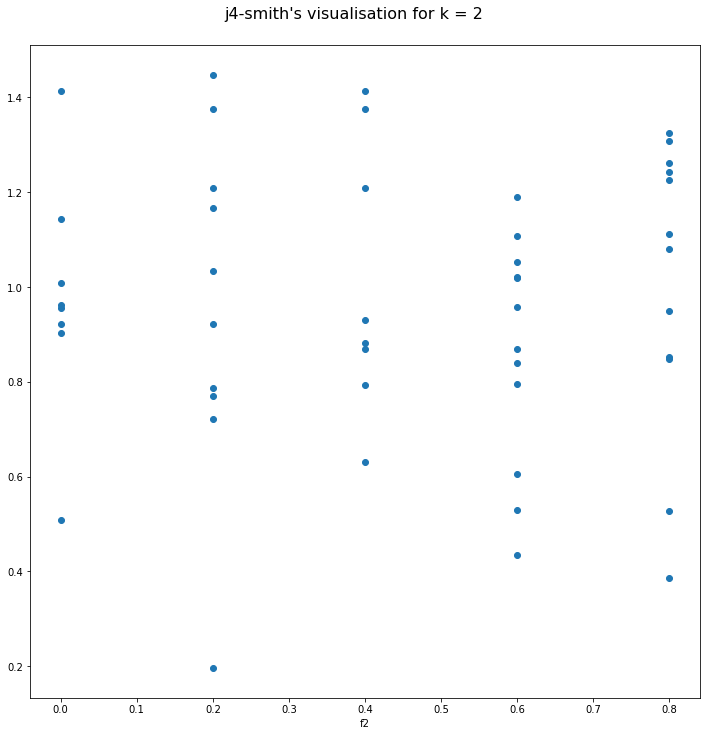

Your code correctly returned first param of type Figure.
You have returned a figure with a single plot in it.
This is not enough to fully visualise this dataset.
Your plot does not appear to have any different colors.
Your visualisation  correctly has your user name in the title.
One or more axis labels are missing.



=== Overall: 
You score 10/20 for the basic content having just one plot,
      and 0/20 for the quality of your clustering.
Altogether, you score 10/50 for the contents of your visualisation.

You score 0/30 for the quality of your labelling,
      and 20/20 for how well your title met the specs..
Altogether, you score 20/50 for presentation of  your visualisation.


In total you score 30/100.

Total score 30 

*****testing.   oneax_randclusters *****



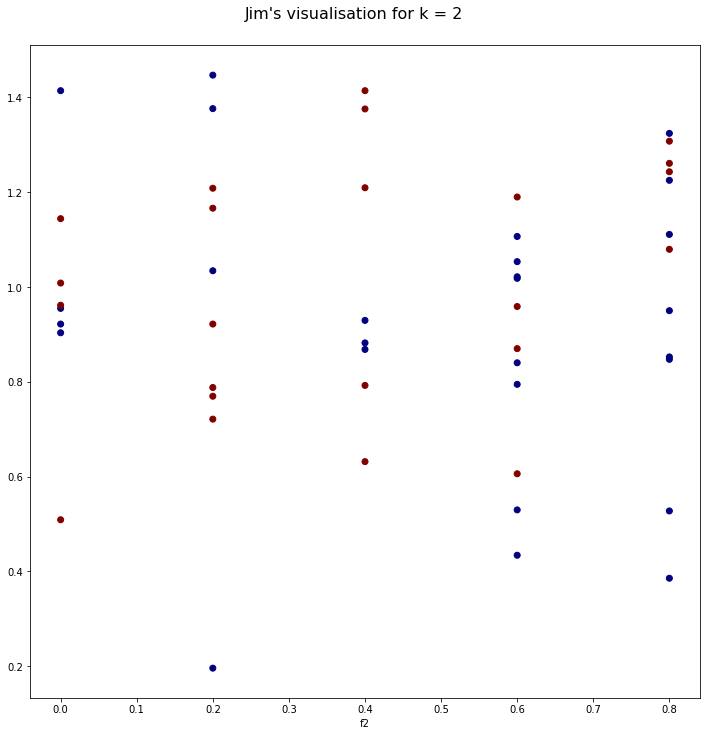

Your code correctly returned first param of type Figure.
You have returned a figure with a single plot in it.
This is not enough to fully visualise this dataset.
Your plot has different colours, but they do not match the  clustering this dataset was designed to contain.
Your visualisation has a title, but it does not contain your user name  as required.
One or more axis labels are missing.



=== Overall: 
You score 10/20 for the basic content having just one plot,
      and 10/20 for the quality of your clustering.
Altogether, you score 20/50 for the contents of your visualisation.

You score 0/30 for the quality of your labelling,
      and 10/20 for how well your title met the specs..
Altogether, you score 10/50 for presentation of  your visualisation.


In total you score 30/100.

Total score 30 

*****testing.   oneFig *****

type of paths is <class 'matplotlib.collections.PathCollection'>


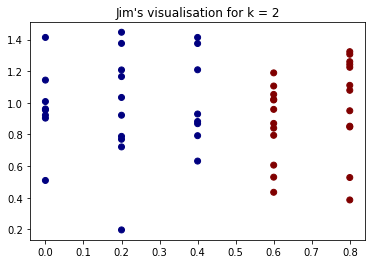

Your code returned a first param of type pathcollection, which is unusual, and will need manual marking.

Total score -1 

*****testing.   grid_clusters *****



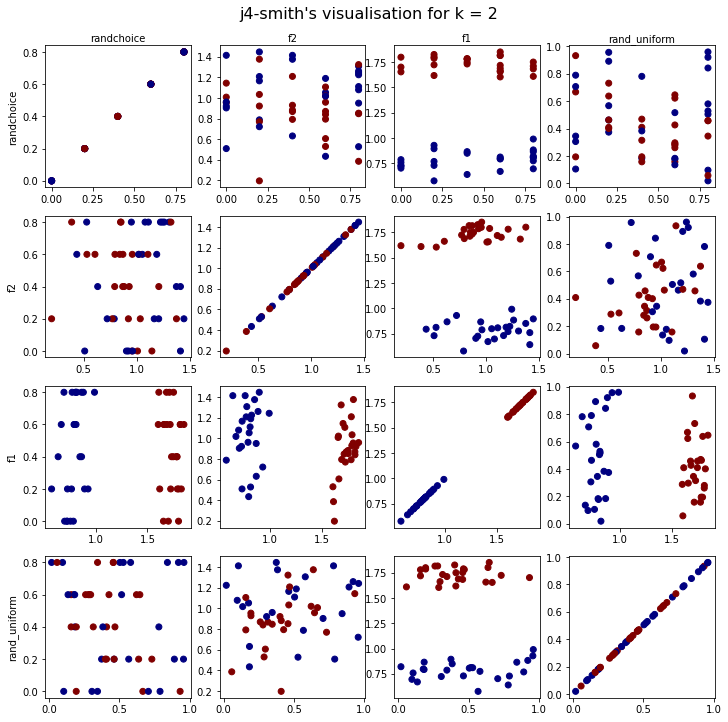

Your code correctly returned first param of type Figure.
You have returned an array with 2 dimensions, of sizes (4, 4), which is the ideal arrangement.
Your ax array correctly contains objects of  type AxesSubplot.
Your plot colours match the ideal clustering for this data.
Your visualisation  correctly has your user name in the title.
Each label appears twice, as expected.



=== Overall: 
You score 20/20 for the basic content having an array of plots.
      and 20/20 for the quality of your clustering.
Altogether, you score 40/50 for the contents of your visualisation.

You score 30/30 for the quality of your labelling,
      and 20/20 for how well your title met the specs..
Altogether, you score 50/50 for presentation of  your visualisation.


In total you score 90/100.

Total score 90 

*****testing.   grid_noclusters *****



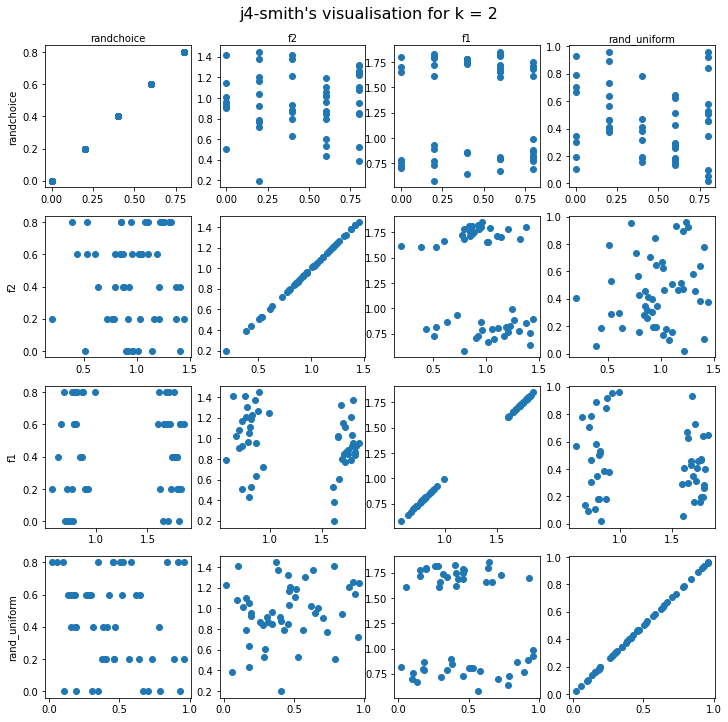

Your code correctly returned first param of type Figure.
You have returned an array with 2 dimensions, of sizes (4, 4), which is the ideal arrangement.
Your ax array correctly contains objects of  type AxesSubplot.
Your plot does not appear to have any different colors.
Your visualisation  correctly has your user name in the title.
Each label appears twice, as expected.



=== Overall: 
You score 20/20 for the basic content having an array of plots.
      and 0/20 for the quality of your clustering.
Altogether, you score 20/50 for the contents of your visualisation.

You score 30/30 for the quality of your labelling,
      and 20/20 for how well your title met the specs..
Altogether, you score 50/50 for presentation of  your visualisation.


In total you score 70/100.

Total score 70 

*****testing.   grid_randclusters *****



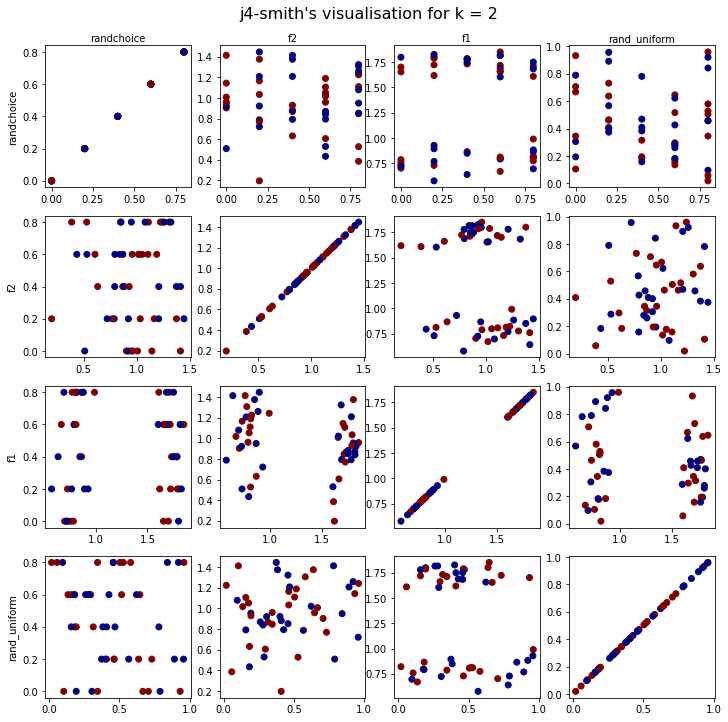

Your code correctly returned first param of type Figure.
You have returned an array with 2 dimensions, of sizes (4, 4), which is the ideal arrangement.
Your ax array correctly contains objects of  type AxesSubplot.
Your plot has different colours, but they do not match the  clustering this dataset was designed to contain.
Your visualisation  correctly has your user name in the title.
Each label appears twice, as expected.



=== Overall: 
You score 20/20 for the basic content having an array of plots.
      and 10/20 for the quality of your clustering.
Altogether, you score 30/50 for the contents of your visualisation.

You score 30/30 for the quality of your labelling,
      and 20/20 for how well your title met the specs..
Altogether, you score 50/50 for presentation of  your visualisation.


In total you score 80/100.

Total score 80 



In [72]:
#this tests that the identification of the type of charts works
for name,func in testing_dict.items():
    
    print("*****testing.   " + name + " *****\n")
    score,msg= check_visualisation(func,datafile,K,feature_names,student_name, name)
    plt.show()
    print(f'{msg}\nTotal score {score} \n')

    